In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/academic-query-classification/sample_submission.csv
/kaggle/input/academic-query-classification/train.csv
/kaggle/input/academic-query-classification/test.csv


# **Importing Libraries :**

In [2]:
# Data processing
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Stats & model building

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# supress warnings
import warnings
warnings.filterwarnings('ignore')


# **Loading The Dataset :**

In [3]:
train_df = pd.read_csv('/kaggle/input/academic-query-classification/train.csv')
test_df = pd.read_csv('/kaggle/input/academic-query-classification/test.csv')

# **Explore the Data and Concise Summary :**

In [4]:
# Looking at the first five rows

train_df.head()

,unique ID,query_text,category
0,0,HTTPS://VIMEO.COM/107297364﻿,junk
1,1,Art and Culture,general
2,2,Differentiate between chemical and biological ...,academic_servable
3,3,nth Term of an AP,academic_servable
4,4,bunmei kaika: aoiza ibunroku saien,junk


In [5]:
test_df.head()

,unique ID,query_text
0,0,yes
1,1,If x = a 2 b 3 c 4 and y = a b 4 c 2 find the ...
2,2,x + 7y=10;3x - 2y=7
3,3,Given tan β = cos θ tan α \[ \begin{array}{l} ...
4,4,Identify the chiral molecule from the following.


In [6]:
# Find the no. of datapoints and features

print('Rows:', train_df.shape[0],'\n' 'Columns: ',train_df.shape[1])

Rows: 5000 
Columns:  3


In [7]:
# see the type of each column

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   unique ID   5000 non-null   int64 
 1   query_text  5000 non-null   object
 2   category    5000 non-null   object
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [8]:
train_df.nunique()

unique ID     5000
query_text    5000
category         5
dtype: int64

In [9]:
# Unique value check of 'category' column

train_df['category'].value_counts()

category
academic_servable        1750
junk                     1000
general                  1000
academic_non_servable     750
conversational            500
Name: count, dtype: int64

In [10]:
# Statistical Summary

train_df.describe(include='all')

,unique ID,query_text,category
count,5000.000000,5000,5000
unique,NaN,5000,5
top,NaN,HTTPS://VIMEO.COM/107297364﻿,academic_servable
freq,NaN,1,1750
mean,2499.500000,NaN,NaN
std,1443.520003,NaN,NaN
min,0.000000,NaN,NaN
25%,1249.750000,NaN,NaN
50%,2499.500000,NaN,NaN
75%,3749.250000,NaN,NaN


**Missing and Duplicate Values :**

In [11]:
# Checking for Null values

train_df.isnull().sum()

unique ID     0
query_text    0
category      0
dtype: int64

In [12]:
# Checking for duplicate values

train_df.duplicated().sum()

0

# **Graphical Analysis :**

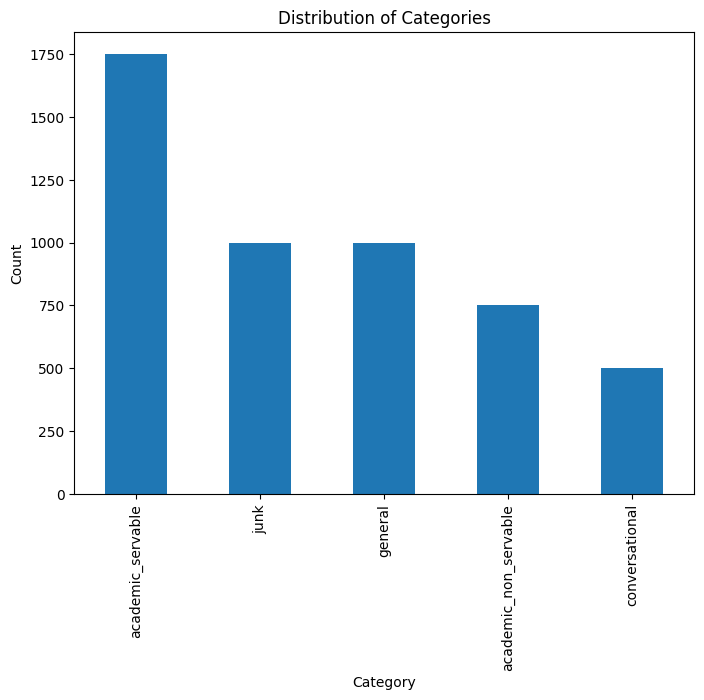

In [13]:
# Check the distribution of categories

plt.figure(figsize=(8, 6))
train_df['category'].value_counts().plot(kind='bar')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

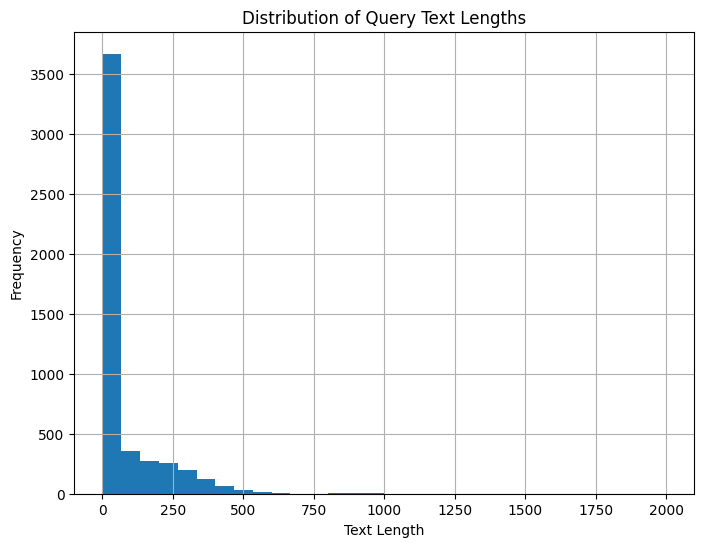

In [14]:
# Check the distribution of query text lengths

train_df['text_length'] = train_df['query_text'].apply(len)
plt.figure(figsize=(8, 6))
train_df['text_length'].hist(bins=30)
plt.title('Distribution of Query Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

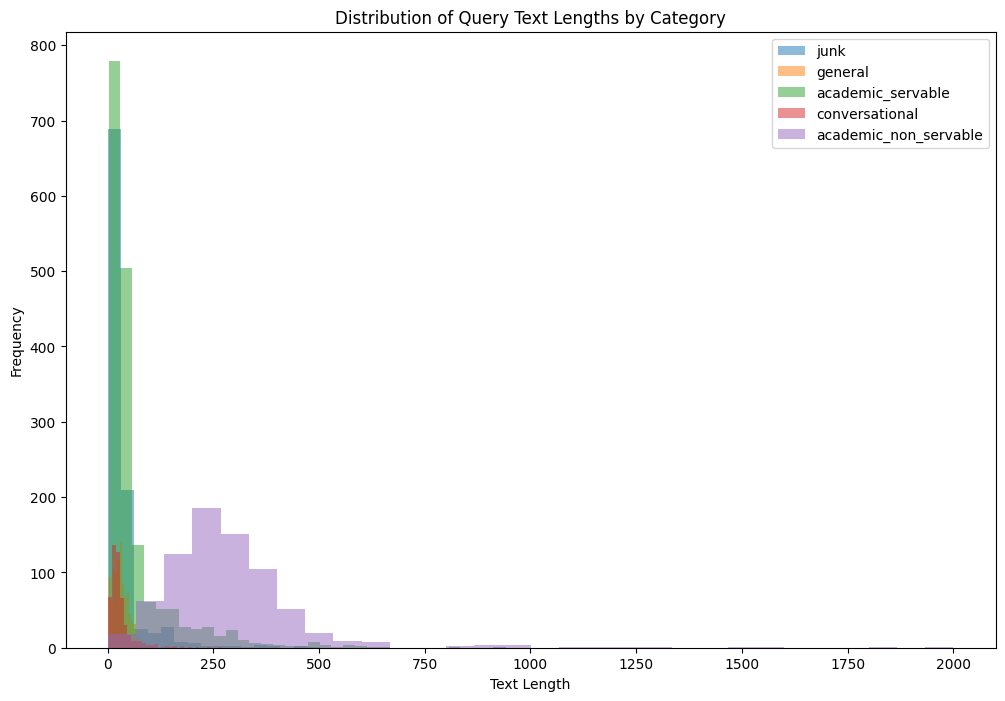

In [15]:
# Check the distribution of text lengths by category

plt.figure(figsize=(12, 8))
for category in train_df['category'].unique():
    subset = train_df[train_df['category'] == category]
    plt.hist(subset['text_length'], bins=30, alpha=0.5, label=category)

plt.title('Distribution of Query Text Lengths by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# **Data Preperation for ML Model :**

In [16]:
X = train_df['query_text']
y = train_df['category']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer1 = TfidfVectorizer(stop_words='english')
X_train_tfidf1 = vectorizer1.fit_transform(X_train)
X_val_tfidf1 = vectorizer1.transform(X_val)
X_test_tfidf1 = vectorizer1.transform(test_df['query_text'])

In [17]:
# Handle class imbalance using SMOTE

smote = SMOTE(random_state=42)
X_train_resampled1, y_train_resampled1 = smote.fit_resample(X_train_tfidf1, y_train)

# **Building the Models :**

* **Train the Naive Bayes classifier with hyperparameter tuning**

In [18]:
param_grid = {
    'alpha': [0.5, 1.0],
}

nb = MultinomialNB()
grid_search = GridSearchCV(nb, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_resampled1, y_train_resampled1)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'alpha': 0.5}
Best cross-validation score: 0.78787023977433


**Evaluate the model :**

In [19]:
# On Validation data

y_pred_val = grid_search.predict(X_val_tfidf1)

print(classification_report(y_val, y_pred_val))
print("Accuracy:", accuracy_score(y_val, y_pred_val))

                       precision    recall  f1-score   support

academic_non_servable       0.38      0.83      0.52       141
    academic_servable       0.77      0.47      0.58       332
       conversational       0.58      0.70      0.63       103
              general       0.71      0.72      0.72       229
                 junk       0.74      0.49      0.59       195

             accuracy                           0.60      1000
            macro avg       0.63      0.64      0.61      1000
         weighted avg       0.68      0.60      0.61      1000

Accuracy: 0.605


**Let's try few defferent steps to see if we can improve the accuracy. We'll start by experimenting with different feature extraction techniques and model selection.**

In [20]:
# we can experiment with different vectorization techniques

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(test_df['query_text'])

In [21]:
# Handle class imbalance using SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

* **Let's try using Support Vector Machines (SVM)**

In [22]:

svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_resampled, y_train_resampled)

SVC(kernel='linear', random_state=42)

* **Evaluate the model :**

In [23]:
# On Validation data

y_pred_svm = svm.predict(X_val_tfidf)
print(classification_report(y_val, y_pred_svm))
print("SVM Accuracy:", accuracy_score(y_val, y_pred_svm))

                       precision    recall  f1-score   support

academic_non_servable       0.77      0.77      0.77       141
    academic_servable       0.76      0.67      0.71       332
       conversational       0.64      0.67      0.65       103
              general       0.85      0.67      0.75       229
                 junk       0.53      0.75      0.62       195

             accuracy                           0.70      1000
            macro avg       0.71      0.71      0.70      1000
         weighted avg       0.72      0.70      0.70      1000

SVM Accuracy: 0.7


* **Let's try using Random Forest**

In [24]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

* **Evaluate the model :**

In [25]:
# On Validation data

y_pred_rf = rf.predict(X_val_tfidf)
print(classification_report(y_val, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))

                       precision    recall  f1-score   support

academic_non_servable       0.96      0.68      0.80       141
    academic_servable       0.74      0.60      0.66       332
       conversational       0.26      0.79      0.40       103
              general       0.86      0.62      0.72       229
                 junk       0.66      0.53      0.59       195

             accuracy                           0.62      1000
            macro avg       0.70      0.64      0.63      1000
         weighted avg       0.73      0.62      0.65      1000

Random Forest Accuracy: 0.622


# **Submission :**

**Since SVM yielded better accuracy, let's proceed with making predictions on the test set using the SVM model and save the final submission**

In [26]:
# Make predictions on the test set using SVM
predictions = svm.predict(X_test_tfidf)

# Save the final submission
output = test_df[['unique ID']].copy()
output['category'] = predictions
output[['unique ID', 'category']].to_csv('submission.csv', index=False)